### DTS - Complete Streets

# 10 - Results Summary

**Author:** rmangan

**Purpose:**

Summarizes analysis results into key metrics for final report. This script utilizes in-memory dataframes from Pandas data science library for various calculations. Dataframes have the benefit of loading the source dataset into memory for analysis, without modifying the source date.

"Spatially Enabled Dataframes" are type of pandas dataframe that also contains geometry (GIS) data.

**This script performs the following functions:**

1. Load modal composite feature class from geodatabase to spatially enabled dataframe
2. Add & calculate various dataframe fields
3. Define sumarization metric values
4. Print out final summarization metric values

**Global Assumptions and Notes:**
1. item
2. item
3. item

**Non-Standard Python Modules utilized:**
1. arcpy 2.7 - required for reading file geodatabase data
2. arcgis 1.83 - required for creating spatial data frame
2. pandas 1.1 - used for results summarization

In [1]:
# import modules
import arcpy
import os
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.gis import GIS

In [2]:
# define variables

# Input Datasets
modal_composite = r"\\dc1vs01\GISProj\H\Honolulu_DTS\D3409300_RailActivation\GeoData\GDB\Modal\Modal Composite 5_3.gdb\modal_composite_05_3"

In [3]:
# define functions

def percent(part,total):
    #return percent
    percent = round(((part/total)*100),3)
    return percent

### 1. Create Dataframe
Load modal composite feature class from geodatabase into spatially enabled dataframe

In [4]:
#Create DF for analysis
df = pd.DataFrame.spatial.from_featureclass(modal_composite)

### 2. Add New Fields
Add and calcluate various fields to the dataframe for analysis summary

In [5]:
#rename land value field
df = df.rename(columns={"LandValue":"Land Value Metric"})

#create new field for future row area & calculate value
df["row_area_future"] = df["row_width_future"] * df["length_ft"]


#add df fields for land value estimates
#land value metric is median land value ($/sq.ft) of all parcels within 1/4 mile of street segment

#total ROW land value
df["row_LV"] = df["mean_row_area"] * df["Land Value Metric"]

#future ROW (if 1986 future greater than 2020 estimate)
df["row_future_LV"] = df["row_area_future"] * df["Land Value Metric"]


#auto land values
df["modal_area_auto_exist_LV"] = df["modal_area_auto_exist"] * df["Land Value Metric"]
df["modal_area_auto_prop_LV"] = df["modal_area_auto_prop"] * df["Land Value Metric"]
df["modal_area_auto_const_LV"] = df["modal_area_auto_const"] * df["Land Value Metric"]


#bike 
df["modal_area_bike_exist_LV"] = df["modal_area_bike_exist"] * df["Land Value Metric"]
df["modal_area_bike_prop_LV"] = df["modal_area_bike_prop"] * df["Land Value Metric"]
df["modal_area_bike_const_LV"] = df["modal_area_bike_const"] * df["Land Value Metric"]


#medians
df["modal_area_medians_exist_LV"] = df["modal_area_medians_exist"] * df["Land Value Metric"]
df["modal_area_medians_prop_LV"] = df["modal_area_medians_prop"] * df["Land Value Metric"]
df["modal_area_medians_const_LV"] = df["modal_area_medians_const"] * df["Land Value Metric"]


#parking
df["modal_area_park_exist_LV"] = df["modal_area_park_exist"] * df["Land Value Metric"]
df["modal_area_park_prop_LV"] = df["modal_area_park_prop"] * df["Land Value Metric"]
df["modal_area_park_const_LV"] = df["modal_area_park_const"] * df["Land Value Metric"]


#Ped
df["modal_area_ped_exist_LV"] = df["modal_area_ped_exist"] * df["Land Value Metric"]
df["modal_area_ped_prop_LV"] = df["modal_area_ped_prop"] * df["Land Value Metric"]
df["modal_area_ped_const_LV"] = df["modal_area_ped_const"] * df["Land Value Metric"]


#Bus
df["modal_area_bus_exist_LV"] = df["modal_area_bus_exist"] * df["Land Value Metric"]
df["modal_area_bus_prop_LV"] = df["modal_area_bus_prop"] * df["Land Value Metric"]
df["modal_area_bus_const_LV"] = df["modal_area_bus_const"] * df["Land Value Metric"]

#### Specify which fields to use in analysis
Define fields from data frame to be used throughout further analysis in a list, fields are later called in functions by referring to field variable and list position. i.e. "CS_type" = fields[3]

In [6]:
#field to use in subsequent dataframe queries 

fields = [
    "SEGMENTID",              #0
    "length_ft",              #1
    "FULLNAME",               #2
    "CS_type",                #3      
    "mean_row_2020",          #4
    "modal_width_max",        #5
    "modal_width_max_diff",   #6
    "modal_width_const",      #7
    "modal_width_const_diff", #8          
    "modal_area_auto_exist",  #9
    "modal_area_auto_prop",   #10
    "modal_area_auto_const",  #11         
    "modal_area_bike_exist",  #12
    "modal_area_bike_prop",   #13
    "modal_area_bike_const",  #14         
    "modal_area_park_exist",  #15
    "modal_area_park_prop",   #16
    "modal_area_park_const",  #17         
    "modal_area_ped_exist",   #18
    "modal_area_ped_prop",    #19
    "modal_area_ped_const",   #20
    "mean_row_area",           #21
    "modal_area_medians_exist",  #22
    "modal_area_medians_prop",   #23
    "modal_area_medians_const",  #24         
    "modal_area_bus_exist",  #25
    "modal_area_bus_prop",   #26
    "modal_area_bus_const",  #27
    "row_area_future"   #28
]

#### Setup Dataframe Filters

Setup dataframe filters to limit the dataframe to specific queries. These filters can then be called and combined with each other to calculate key metrics.

In [7]:
#Owner Queries

#filter for Owner = CITY OR Owner = City OR Owner = VARIOUS
f_owner = (df["OWNER"] == "CITY") | (df["OWNER"] == "City") | (df["OWNER"] == "VARIOUS")


#Bike Queries

#filter for Existing Bike = Shared Roadway
f_bike_exist_sharedroad = (df["Fac_Type_BE"] == "Shared Roadway")

#filter for Existing Bike = Shared Use Path
f_bike_exist_sharedpath = (df["Fac_Type_BE"] == "Shared Use Path")

#filter for exiting bike NOT = (Shared Road OR Shared Use Path)
#used to identify non-shared bike facilities
f_bike_exist_distinct = ~ ((df["Fac_Type_BE"] == "Shared Roadway") | (df["Fac_Type_BE"] == "Shared Use Path"))

#filter for proposed bike = Shared Roadway
f_bike_prop_sharedroad = (df["Fac_Type_BP"] == "Shared Roadway")

#filter for redev bike = Shared Roadway
f_bike_redev_sharedroad = (df["Fac_Type_BR"] == "Shared Roadway")

#filter for prop bike = Shared Use Path
f_bike_prop_sharedpath = (df["Fac_Type_BP"] == "Shared Use Path")

#filter for redeve bike = Shared Use Path
f_bike_redev_sharedpath = (df["Fac_Type_BR"] == "Shared Use Path")

#fitler for non-shared future bike facilites
f_bike_prop_distinct = ~(f_bike_prop_sharedroad  | f_bike_redev_sharedroad | f_bike_prop_sharedpath | f_bike_redev_sharedpath )


#ROW Queries

#filter for segmnts where unconstrained modal width > const modal width (segments where prioritization logic was used)
f_reductions = (df["modal_width_max"] > df["modal_width_const"])

#filter for unconstrained scenario segements where total width > current ROW
f_unconst_over = df["modal_width_max_diff"] >= 0

#filter for unconstrained scenario segments where total width < current ROW
f_unconst_under = df["modal_width_max_diff"] <= 0

#filter for constrained scenario segements where total width > current ROW
f_const_over = df["modal_width_const_diff"] >= 0

#filter for constrained scenario segments where total width < current ROW
f_const_under = df["modal_width_const_diff"] <= 0


#EJ/SLR Queries

#filter for EJ > 50%
f_ej = df["ej_percent"] > .5

#filter for SLR > 50%
f_slr = df["SLR_percent"] > .5

### 3. Define Metrics

Use previously defined filters in conjuction with specific fields to assign metrics to individual variables.

#### Overal Metrics

In [8]:
#Total Miles (all data)
#no dataframe filter, summarize lenfth_ft field & convert to miles. Round output to 0 decimal places.
total_miles = round(df.loc[:, fields].sum()[1]/5280)

#Total Miles (all data) where EJ > 50%
#EJ > 50% dataframe filter, sum length_ft and convert to miles
total_miles_ej = round(df.loc[f_ej, fields].sum()[1]/5280)

#Total Miles (all data) where SLR > 50%
total_miles_slr = round(df.loc[f_slr, fields].sum()[1]/5280)



#Total Area (all data) - converted to acres
total_area = round(df.loc[:, fields].sum()[21]/43560)

#Project (Owner = City & Various)
project_miles = round(df.loc[f_owner, fields].sum()[1]/5280)
project_miles_ej = round(df.loc[f_owner & f_ej, fields].sum()[1]/5280)
project_miles_slr = round(df.loc[f_owner & f_slr, fields].sum()[1]/5280)
project_area = round(df.loc[f_owner, fields].sum()[21]/43560)
project_area_future = round(df.loc[f_owner, fields].sum()[28]/43560)


unconst_over = round(df.loc[f_unconst_over & f_owner,fields].sum()[1]/5280)
unconst_under = round(df.loc[f_unconst_under & f_owner,fields].sum()[1]/5280)

const_over = round(df.loc[f_const_over & f_owner,fields].sum()[1]/5280)
const_under = round(df.loc[f_const_under & f_owner,fields].sum()[1]/5280)

land_value = (round(df["row_LV"].sum()/1000000))
land_value_future = (round(df["row_future_LV"].sum()/1000000))

land_value_proj = (round(df.loc[f_owner,"row_LV"].sum()/1000000))
land_value_proj_future = (round(df.loc[f_owner,"row_future_LV"].sum()/1000000))

#### Individual Modal Metrics

In [9]:
#auto
auto_area_exist = round(df.loc[f_owner,fields].sum()[9]/43560)
auto_area_exist_ej = round(df.loc[f_owner & f_ej,fields].sum()[9]/43560)
auto_area_exist_slr = round(df.loc[f_owner & f_slr,fields].sum()[9]/43560)

auto_area_prop = round(df.loc[f_owner,fields].sum()[10]/43560)
auto_area_prop_ej = round(df.loc[f_owner & f_ej,fields].sum()[10]/43560)
auto_area_prop_slr = round(df.loc[f_owner & f_slr,fields].sum()[10]/43560)

auto_area_const = round(df.loc[f_owner,fields].sum()[11]/43560)
auto_area_const_ej = round(df.loc[f_owner & f_ej,fields].sum()[11]/43560)
auto_area_const_slr = round(df.loc[f_owner & f_slr,fields].sum()[11]/43560)

auto_current_value = (round(df.loc[f_owner,"modal_area_auto_exist_LV"].sum()/1000000))
auto_prop_value = (round(df.loc[f_owner,"modal_area_auto_prop_LV"].sum()/1000000))
auto_const_value = (round(df.loc[f_owner,"modal_area_auto_const_LV"].sum()/1000000))

In [10]:
#bike
bike_area_exist = round(df.loc[f_owner,fields].sum()[12]/43560)
bike_area_exist_distinct = round(df.loc[f_owner & f_bike_exist_distinct,fields].sum()[12]/43560)

bike_area_exist_sharedroad = round(df.loc[f_owner & f_bike_exist_sharedroad,fields].sum()[12]/43560)
bike_area_exist_sharedpath = round(df.loc[f_owner & f_bike_exist_sharedpath,fields].sum()[12]/43560)

bike_area_exist_ej = round(df.loc[f_owner & f_ej,fields].sum()[12]/43560)
bike_area_exist_slr = round(df.loc[f_owner & f_slr,fields].sum()[12]/43560)

bike_area_exist_distinct_ej = round(df.loc[f_owner & f_bike_exist_distinct & f_ej,fields].sum()[12]/43560)
bike_area_exist_distinct_slr = round(df.loc[f_owner & f_bike_exist_distinct & f_slr,fields].sum()[12]/43560)

bike_area_prop = round(df.loc[f_owner,fields].sum()[13]/43560)
bike_area_prop_distinct = round(df.loc[f_owner & f_bike_prop_distinct,fields].sum()[13]/43560)

bike_area_prop_sharedroad = round(df.loc[f_owner & (f_bike_prop_sharedroad | f_bike_redev_sharedroad),fields].sum()[13]/43560)
bike_area_prop_sharedpath = round(df.loc[f_owner & (f_bike_prop_sharedpath | f_bike_redev_sharedpath),fields].sum()[13]/43560)

bike_area_prop_ej = round(df.loc[f_owner & f_ej,fields].sum()[13]/43560)
bike_area_prop_distinct_ej = round(df.loc[f_owner & f_bike_prop_distinct & f_ej,fields].sum()[13]/43560)
bike_area_prop_slr = round(df.loc[f_owner & f_slr,fields].sum()[13]/43560)
bike_area_prop_distinct_slr = round(df.loc[f_owner & f_bike_prop_distinct & f_slr,fields].sum()[13]/43560)

bike_area_const = round(df.loc[f_owner,fields].sum()[14]/43560)
bike_area_const_distinct = round(df.loc[f_owner & f_bike_prop_distinct,fields].sum()[14]/43560)

bike_area_const_sharedroad = round(df.loc[f_owner & (f_bike_prop_sharedroad | f_bike_redev_sharedroad),fields].sum()[14]/43560)
bike_area_const_sharedpath = round(df.loc[f_owner & (f_bike_prop_sharedpath | f_bike_redev_sharedpath),fields].sum()[14]/43560)

bike_area_const_ej = round(df.loc[f_owner & f_ej,fields].sum()[14]/43560)
bike_area_const_distinct_ej = round(df.loc[f_owner & f_bike_prop_distinct & f_ej,fields].sum()[14]/43560)
bike_area_const_slr = round(df.loc[f_owner & f_slr,fields].sum()[14]/43560)
bike_area_const_distinct_slr = round(df.loc[f_owner & f_bike_prop_distinct & f_slr,fields].sum()[14]/4356)
                            
bike_current_value = (round(df.loc[f_owner,"modal_area_bike_exist_LV"].sum()/1000000))
bike_distinct_current_value = (round(df.loc[f_owner & f_bike_exist_distinct,"modal_area_bike_exist_LV"].sum()/1000000))

bike_prop_value = (round(df.loc[f_owner,"modal_area_bike_prop_LV"].sum()/1000000))
bike_prop_distinct_value = (round(df.loc[f_owner & f_bike_prop_distinct,"modal_area_bike_prop_LV"].sum()/1000000))

bike_const_value = (round(df.loc[f_owner,"modal_area_bike_const_LV"].sum()/1000000))
bike_const_distinct_value = (round(df.loc[f_owner & f_bike_prop_distinct,"modal_area_bike_const_LV"].sum()/1000000))

In [11]:
#medians
medians_area_exist = round(df.loc[f_owner,fields].sum()[22]/43560)
medians_area_exist_ej = round(df.loc[f_owner & f_ej,fields].sum()[22]/43560)
medians_area_exist_slr = round(df.loc[f_owner & f_slr,fields].sum()[22]/43560)

medians_area_prop = round(df.loc[f_owner,fields].sum()[23]/43560)
medians_area_prop_ej = round(df.loc[f_owner & f_ej,fields].sum()[23]/43560)
medians_area_prop_slr = round(df.loc[f_owner & f_slr,fields].sum()[23]/43560)

medians_area_const = round(df.loc[f_owner,fields].sum()[24]/43560)
medians_area_const_ej = round(df.loc[f_owner & f_ej,fields].sum()[24]/43560)
medians_area_const_slr = round(df.loc[f_owner & f_slr,fields].sum()[24]/43560)

medians_current_value = (round(df.loc[f_owner,"modal_area_medians_exist_LV"].sum()/1000000))
medians_prop_value = (round(df.loc[f_owner,"modal_area_medians_prop_LV"].sum()/1000000))
medians_const_value = (round(df.loc[f_owner,"modal_area_medians_const_LV"].sum()/1000000))

In [12]:
#parking
park_area_exist = round(df.loc[f_owner,fields].sum()[15]/43560)
park_area_exist_ej = round(df.loc[f_owner & f_ej,fields].sum()[15]/43560)
park_area_exist_slr = round(df.loc[f_owner & f_slr,fields].sum()[15]/43560)

park_area_prop = round(df.loc[f_owner,fields].sum()[16]/43560)
park_area_prop_ej = round(df.loc[f_owner & f_ej,fields].sum()[16]/43560)
park_area_prop_slr = round(df.loc[f_owner & f_slr,fields].sum()[16]/43560)

park_area_const = round(df.loc[f_owner,fields].sum()[17]/43560)
park_area_const_ej = round(df.loc[f_owner & f_ej,fields].sum()[17]/43560)
park_area_const_slr = round(df.loc[f_owner & f_slr,fields].sum()[17]/43560)

park_current_value = (round(df.loc[f_owner,"modal_area_park_exist_LV"].sum()/1000000))
park_prop_value = (round(df.loc[f_owner,"modal_area_park_prop_LV"].sum()/1000000))
park_const_value = (round(df.loc[f_owner,"modal_area_park_const_LV"].sum()/1000000))

In [13]:
#Ped
ped_area_exist = round(df.loc[f_owner,fields].sum()[18]/43560)
ped_area_exist_ej = round(df.loc[f_owner & f_ej,fields].sum()[18]/43560)
ped_area_exist_slr = round(df.loc[f_owner & f_slr,fields].sum()[18]/43560)

ped_area_prop = round(df.loc[f_owner,fields].sum()[19]/43560)
ped_area_prop_ej = round(df.loc[f_owner & f_ej,fields].sum()[19]/43560)
ped_area_prop_slr = round(df.loc[f_owner & f_slr,fields].sum()[19]/43560)

ped_area_const = round(df.loc[f_owner,fields].sum()[20]/43560)
ped_area_const_ej = round(df.loc[f_owner & f_ej,fields].sum()[20]/43560)
ped_area_const_slr = round(df.loc[f_owner & f_slr,fields].sum()[20]/43560)

ped_current_value = (round(df.loc[f_owner,"modal_area_ped_exist_LV"].sum()/1000000))
ped_prop_value = (round(df.loc[f_owner,"modal_area_ped_prop_LV"].sum()/1000000))
ped_const_value = (round(df.loc[f_owner,"modal_area_ped_const_LV"].sum()/1000000))

In [14]:
#bus
bus_area_exist = round(df.loc[f_owner,fields].sum()[25]/43560)
bus_area_exist_ej = round(df.loc[f_owner & f_ej,fields].sum()[25]/43560)
bus_area_exist_slr = round(df.loc[f_owner & f_slr,fields].sum()[25]/43560)

bus_area_prop = round(df.loc[f_owner,fields].sum()[26]/43560)
bus_area_prop_ej = round(df.loc[f_owner & f_ej,fields].sum()[26]/43560)
bus_area_prop_slr = round(df.loc[f_owner & f_slr,fields].sum()[26]/43560)

bus_area_const = round(df.loc[f_owner,fields].sum()[27]/43560)
bus_area_const_ej = round(df.loc[f_owner & f_ej,fields].sum()[27]/43560)
bus_area_const_slr = round(df.loc[f_owner & f_slr,fields].sum()[27]/43560)

bus_current_value = (round(df.loc[f_owner,"modal_area_bus_exist_LV"].sum()/1000000))
bus_prop_value = (round(df.loc[f_owner,"modal_area_bus_prop_LV"].sum()/1000000))
bus_const_value = (round(df.loc[f_owner,"modal_area_bus_const_LV"].sum()/1000000))

### 4. Print Final Metrics

After defining all metrics as variables, load the metrics to a new pandas dataframe for easier visualization and reporting. 

#### Load metrics to new Dataframe

In [15]:
#load metric variables to dict, key will be column name, values will be rows
results_dict = {'Metric Category': ["All Data", 
                                "City Streets",
                                "Auto",
                                "Auto",
                                "Auto",
                                "Bike",
                                "Bike",
                                "Bike",
                                "Medians",
                                "Medians",
                                "Medians",
                                "Parking",
                                "Parking",
                                "Parking",
                                "Bus",
                                "Bus",
                                "Bus"
                               ],
                'Scenario': [
                    "Existing",
                    "Existing",
                    "Existing",
                    "Proposed",
                    "Constrained",
                    "Existing",
                    "Proposed",
                    "Constrained",
                    "Existing",
                    "Proposed",
                    "Constrained",
                    "Existing",
                    "Proposed",
                    "Constrained",
                    "Existing",
                    "Proposed",
                    "Constrained"
                            ],
                'Miles': [
                    total_miles,
                    project_miles,
                    None, #Null for Auto Miles
                     None, #Null for Auto Miles
                     None, #Null for Auto Miles
                     None, #Null for Bike Miles
                     None, #Null for Bike Miles
                     None, #Null for Bike Miles
                     None, #Null for Median Miles
                     None, #Null for Median Miles
                     None, #Null for Median Miles
                     None, #Null for Parking Miles
                     None, #Null for Parking Miles
                     None, #Null for Parking Miles
                     None, #Null for Bus Miles
                     None, #Null for Bus Miles
                     None, #Null for Bus Miles
                         ],
                'Area (acres)': [
                    total_area,
                    project_area,
                    auto_area_exist,
                    auto_area_prop,
                    auto_area_const,
                    bike_area_exist_distinct,
                    bike_area_prop_distinct,
                    bike_area_const_distinct,
                    medians_area_exist,
                    medians_area_prop,
                    medians_area_const,
                    park_area_exist,
                    park_area_prop,
                    park_area_const,
                    bus_area_exist,
                    bus_area_prop,
                    bus_area_const],
                'Land Value ($M USD)': [
                    land_value,
                    land_value_proj,
                    auto_current_value,
                    auto_prop_value,
                    auto_const_value,
                    bike_distinct_current_value,
                    bike_prop_distinct_value,
                    bike_const_distinct_value,
                    medians_current_value,
                    medians_prop_value,
                    medians_const_value,
                    park_current_value,
                    park_prop_value,
                    park_const_value,
                    bus_current_value,
                    bus_prop_value,
                    bus_const_value],
                'EJ Acres': [
                    None, #NEEDS UPDATE
                    None, #NEEDS UPDATE
                    auto_area_exist_ej,
                    auto_area_prop_ej,
                    auto_area_const_ej,
                    bike_area_exist_distinct_ej,
                    bike_area_prop_distinct_ej,
                    bike_area_const_distinct_ej,
                    medians_area_exist_ej,
                    medians_area_prop_ej,
                    medians_area_const_ej,
                    park_area_exist_ej,
                    park_area_prop_ej,
                    park_area_const_ej,
                    bus_area_exist_ej,
                    bus_area_prop_ej,
                    bus_area_const_ej],
                'SLR Acres': [
                    None, #needs update
                    None, #needs update
                    auto_area_exist_slr,
                    auto_area_prop_slr,
                    auto_area_const_slr,
                    bike_area_exist_distinct_slr,
                    bike_area_prop_distinct_slr,
                    bike_area_const_distinct_slr,
                    medians_area_exist_slr,
                    medians_area_prop_slr,
                    medians_area_const_slr,
                    park_area_exist_slr,
                    park_area_prop_slr,
                    park_area_const_slr,
                    bus_area_exist_slr,
                    bus_area_prop_slr,
                    bus_area_const_slr]
               }



In [16]:
#create new df from dict
new_df = pd.DataFrame.from_dict(results_dict)

In [17]:
#add new fields to the DF

#create new field EJ %
new_df["EJ % (by area)"] = (new_df["EJ Acres"] / new_df["Area (acres)"])*100

#create new field EJ %
new_df["SLR % (by area)"] = (new_df["SLR Acres"] / new_df["Area (acres)"])*100

#create new field for Metric Label
new_df["Metric Description"] = new_df["Metric Category"] +" " + new_df["Scenario"]

In [26]:
#print out all summary metrics
new_df

,Metric Category,Scenario,Miles,Area (acres),Land Value ($M USD),EJ Acres,SLR Acres,EJ % (by area),SLR % (by area),Metric Description
0,All Data,Existing,2059.0,14838,58870,NaN,NaN,NaN,NaN,All Data Existing
1,City Streets,Existing,1449.0,9603,43584,NaN,NaN,NaN,NaN,City Streets Existing
2,Auto,Existing,NaN,4434,20938,889.0,85.0,20.049617,1.917005,Auto Existing
3,Auto,Proposed,NaN,4510,21326,901.0,87.0,19.977827,1.929047,Auto Proposed
4,Auto,Constrained,NaN,4498,21250,901.0,87.0,20.031125,1.934193,Auto Constrained
5,Bike,Existing,NaN,46,297,9.0,1.0,19.565217,2.173913,Bike Existing
6,Bike,Proposed,NaN,257,1466,53.0,7.0,20.622568,2.723735,Bike Proposed
7,Bike,Constrained,NaN,241,1340,50.0,52.0,20.746888,21.576763,Bike Constrained
8,Medians,Existing,NaN,150,663,30.0,1.0,20.000000,0.666667,Medians Existing
9,Medians,Proposed,NaN,150,663,30.0,1.0,20.000000,0.666667,Medians Proposed


In [18]:
#print out for Existing Scenario
new_df[new_df["Scenario"]=="Existing"]

,Metric Category,Scenario,Miles,Area (acres),Land Value ($M USD),EJ Acres,SLR Acres,EJ % (by area),SLR % (by area),Metric Description
0,All Data,Existing,2059.0,14838,58870,NaN,NaN,NaN,NaN,All Data Existing
1,City Streets,Existing,1449.0,9603,43584,NaN,NaN,NaN,NaN,City Streets Existing
2,Auto,Existing,NaN,4434,20938,889.0,85.0,20.049617,1.917005,Auto Existing
5,Bike,Existing,NaN,46,297,9.0,1.0,19.565217,2.173913,Bike Existing
8,Medians,Existing,NaN,150,663,30.0,1.0,20.000000,0.666667,Medians Existing
11,Parking,Existing,NaN,1922,8953,340.0,35.0,17.689906,1.821020,Parking Existing
14,Bus,Existing,NaN,3,39,1.0,0.0,33.333333,0.000000,Bus Existing


In [29]:
#print out for Proposed Scenario
df_plot = new_df[new_df["Metric Category"]=="Auto"]

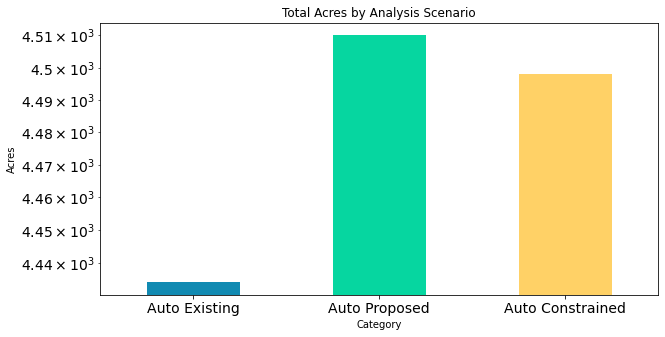

In [40]:
bar = df_plot.plot.bar(y="Area (acres)",
                       x="Metric Description",
                       figsize=(10,5),
                       fontsize=14,
                       xlabel = "Category",
                       rot=0,
                       ylabel="Acres",
                       logy=True,
                       legend=False,
                       title="Total Acres by Modal",
                       color = ["#118ab2", "#06d6a0", "#ffd166"]
                
               )

#### Print Metrics (QC during ouput dataframe development)

improvements: generate a dataframe that contains metric information (DONE) - remove when QC complete

In [ ]:
#Overall

print("\n#Totals (all data)#")
print("Miles: {0:,}".format(total_miles))
print("Acres: {0:,} (${1:,}M)".format(total_area,land_value))
print("EJ: {0:,} ({1}%)".format(total_miles_ej, percent(total_miles_ej, total_miles)))
print("SLR: {0:,} ({1}%)".format(total_miles_slr,percent(total_miles_slr,total_miles)))


print("\n#Totals (City & Various)#")
print("Miles: {0:,}".format(project_miles))
print("Acres: {0:,} (${1:,}M)".format(project_area,land_value_proj))
print("Acres (future): {0:,} (${1:,}M)".format(project_area_future,land_value_proj))
print("EJ: {0:,} ({1}%)".format(project_miles_ej, percent(project_miles_ej, project_miles)))
print("SLR: {0:,} ({1}%)".format(project_miles_slr,percent(project_miles_slr,project_miles)))


print("\n#Unconstrained Modal#")
print("Miles where Width > ROW: {0:,} ({1}%)".format(unconst_over, percent(unconst_over,project_miles)))
print("Miles where Width < ROW: {0:,} ({1}%)".format(unconst_under, percent(unconst_under,project_miles)))

print("\n#Constrained Modal#")
print("Miles where Width > ROW: {0:,} ({1}%)".format(const_over, percent(const_over,project_miles)))
print("Miles where Width < ROW: {0:,} ({1}%)".format(const_under, percent(const_under,project_miles) ))

In [ ]:
#Individual Modal Types

#Auto
print("\n#Individual Modal Metrics (acres)")
print("\n#Auto#")
print("Exist: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(auto_area_exist,
                                                                           auto_current_value,
                                                                           auto_area_exist_ej,
                                                                           percent(auto_area_exist_ej,auto_area_exist),
                                                                           auto_area_exist_slr,
                                                                           percent(auto_area_exist_slr,auto_area_exist)))
print("Prop: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(auto_area_prop,
                                                                           auto_prop_value,
                                                                           auto_area_prop_ej,
                                                                           percent(auto_area_prop_ej,auto_area_prop),
                                                                           auto_area_prop_slr,
                                                                           percent(auto_area_prop_slr,auto_area_prop)))
print("Const: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(auto_area_const,
                                                                           auto_const_value,
                                                                           auto_area_const_ej,
                                                                           percent(auto_area_const_ej,auto_area_const),
                                                                           auto_area_const_slr,
                                                                           percent(auto_area_const_slr,auto_area_const)))

In [ ]:
print("\n#Bike#")
print("Exist: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bike_area_exist,
                                                                           bike_current_value,
                                                                           bike_area_exist_ej,
                                                                           percent(bike_area_exist_ej,bike_area_exist),
                                                                           bike_area_exist_slr,
                                                                           percent(bike_area_exist_slr,bike_area_exist)))

print("Exist (Distinct): {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bike_area_exist_distinct,
                                                                           bike_distinct_current_value,
                                                                           bike_area_exist_distinct_ej,
                                                                           percent(bike_area_exist_distinct_ej,bike_area_exist),
                                                                           bike_area_exist_distinct_slr,
                                                                           percent(bike_area_exist_distinct_slr,bike_area_exist)))

print("Shared Roadway: {0}".format(bike_area_exist_sharedroad))
print("Shared Use Path: {0}".format(bike_area_exist_sharedpath))
print("\nProp: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bike_area_prop,
                                                                           bike_prop_value,
                                                                           bike_area_prop_ej,
                                                                           percent(bike_area_prop_ej,bike_area_prop),
                                                                           bike_area_prop_slr,
                                                                           percent(bike_area_prop_slr,bike_area_prop)))
print("Prop (Distinct): {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bike_area_prop_distinct,
                                                                           bike_prop_distinct_value,
                                                                           bike_area_prop_distinct_ej,
                                                                           percent(bike_area_prop_distinct_ej,bike_area_prop),
                                                                           bike_area_prop_distinct_slr,
                                                                           percent(bike_area_prop_distinct_slr,bike_area_prop)))

print("Shared Roadway: {0}".format(bike_area_prop_sharedroad))
print("Shared Use Path: {0}".format(bike_area_prop_sharedpath))
print("\nConst: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bike_area_const,
                                                                           bike_const_value,
                                                                           bike_area_const_ej,
                                                                           percent(bike_area_const_ej,bike_area_const),
                                                                           bike_area_const_slr,
                                                                           percent(bike_area_const_slr,bike_area_const)))
print("Const (Distinct): {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bike_area_const_distinct,
                                                                           bike_const_distinct_value,
                                                                           bike_area_const_distinct_ej,
                                                                           percent(bike_area_const_distinct_ej,bike_area_const),
                                                                           bike_area_const_distinct_slr,
                                                                           percent(bike_area_const_distinct_slr,bike_area_const)))


print("Shared Roadway: {0}".format(bike_area_const_sharedroad))
print("Shared Use Path: {0}".format(bike_area_const_sharedpath))

In [ ]:
print("\n#Medians#")
print("Exist: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(medians_area_exist,
                                                                           medians_current_value,
                                                                           medians_area_exist_ej,
                                                                           percent(medians_area_exist_ej,medians_area_exist),
                                                                           medians_area_exist_slr,
                                                                           percent(medians_area_exist_slr,medians_area_exist)))
print("Prop: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(medians_area_prop,
                                                                           medians_prop_value,
                                                                           medians_area_prop_ej,
                                                                           percent(medians_area_prop_ej,medians_area_prop),
                                                                           medians_area_prop_slr,
                                                                           percent(medians_area_prop_slr,medians_area_prop)))
print("Const: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(medians_area_const,
                                                                           medians_const_value,
                                                                           medians_area_const_ej,
                                                                           percent(medians_area_const_ej,medians_area_const),
                                                                           medians_area_const_slr,
                                                                           percent(medians_area_const_slr,medians_area_const)))

In [ ]:
print("\n#Parking#")
print("Exist: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(park_area_exist,
                                                                           park_current_value,
                                                                           park_area_exist_ej,
                                                                           percent(park_area_exist_ej,park_area_exist),
                                                                           park_area_exist_slr,
                                                                           percent(park_area_exist_slr,park_area_exist)))
print("Prop: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(park_area_prop,
                                                                           park_prop_value,
                                                                           park_area_prop_ej,
                                                                           percent(park_area_prop_ej,park_area_prop),
                                                                           park_area_prop_slr,
                                                                           percent(park_area_prop_slr,park_area_prop)))
print("Const: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(park_area_const,
                                                                           park_const_value,
                                                                           park_area_const_ej,
                                                                           percent(park_area_const_ej,park_area_const),
                                                                           park_area_const_slr,
                                                                           percent(park_area_const_slr,park_area_const)))

In [ ]:
print("\n#Ped#")
print("Exist: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(ped_area_exist,
                                                                           ped_current_value,
                                                                           ped_area_exist_ej,
                                                                           percent(ped_area_exist_ej,ped_area_exist),
                                                                           ped_area_exist_slr,
                                                                           percent(ped_area_exist_slr,ped_area_exist)))

print("Prop: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(ped_area_prop,
                                                                           ped_prop_value,
                                                                           ped_area_prop_ej,
                                                                           percent(ped_area_prop_ej,ped_area_prop),
                                                                           ped_area_prop_slr,
                                                                           percent(ped_area_prop_slr,ped_area_prop)))
print("Const: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(ped_area_const,
                                                                           ped_const_value,
                                                                           ped_area_const_ej,
                                                                           percent(ped_area_const_ej,ped_area_const),
                                                                           ped_area_const_slr,
                                                                           percent(ped_area_const_slr,ped_area_const)))

In [ ]:
print("\n#Bus (dedicated bus lanes - overlaps with Auto area)#")
print("Exist: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bus_area_exist,
                                                                           bus_current_value,
                                                                           bus_area_exist_ej,
                                                                           percent(bus_area_exist_ej,bus_area_exist),
                                                                           bus_area_exist_slr,
                                                                           percent(bus_area_exist_slr,bus_area_exist)))
print("Prop: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bus_area_prop,
                                                                           bus_prop_value,
                                                                           bus_area_prop_ej,
                                                                           percent(bus_area_prop_ej,bus_area_prop),
                                                                           bus_area_prop_slr,
                                                                           percent(bus_area_prop_slr,bus_area_prop)))
print("Const: {0:,} (${1:,}M), EJ: {2:,} ({3}%), SLR: {4:,} ({5}%)".format(bus_area_const,
                                                                           bus_const_value,
                                                                           bus_area_const_ej,
                                                                           percent(bus_area_const_ej,bus_area_const),
                                                                           bus_area_const_slr,
                                                                           percent(bus_area_const_slr,bus_area_const)))